In [107]:
import numpy as np
from matplotlib import pyplot as plt


# ------------------------------------------------------------------------------------------------
# EXAMPLE 1
Mainly based on the books author's code. But little adjustments were done from my side.

In [108]:
from sklearn import datasets

np.random.seed(42)

# CREATE DATA
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [109]:
X.shape, y.shape

((150, 2), (150,))

In [110]:
# check what unique values are in y
y.unique()

array([False,  True])

In [111]:
y.value_counts()

target
False    100
True      50
Name: count, dtype: int64

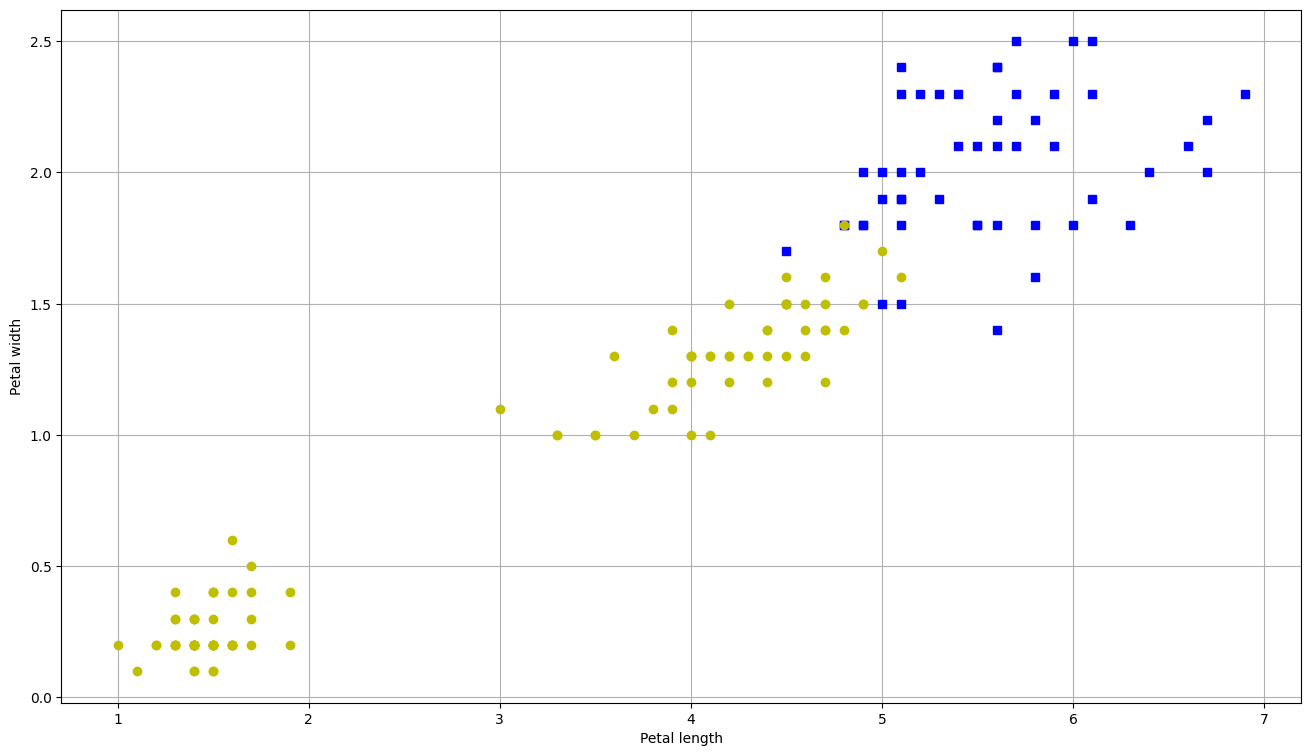

In [112]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")  # blue squares
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")  # yellow circles
plt.xlabel("Petal length")
plt.ylabel("Petal width")
# plt.gca().set_aspect("equal") # make aspect ratio equal of x and y axis
plt.grid()

In [113]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [114]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [115]:
# CREATE ESTIMATOR
from sklearn.base import BaseEstimator
from AI.algorithms_from_scratch.my_base_models import MySupportVectorClassiferBase


class MyLinearSoftMargSVC(BaseEstimator, MySupportVectorClassiferBase):
    def __init__(self, C=1, eta0=1, eta_d=1000, n_epochs=1000):
        """
        This class uses soft margin SVM to classify the data. It uses hinge loss as a loss function.
        This means that if you have parameter "C" then you are using soft margin SVM.
        
        :param C: Regularization parameter 
        :param eta0: Learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param random_state: 
        """

        super().__init__()
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.Js = []  # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None

    def fit(self, X, y):
        # Random initialization of weights and bias
        coef_ = np.random.randn(X.shape[1], 1)  # number of feature weights
        intercept_ = 0

        X_t, t = self.transform_datapoints_to_positive_and_negative(X, y)

        # Training
        for epoch in range(self.n_epochs):
            X_t_sv, t_sv, _ = self.select_margin_violators(X_t, t, intercept_, coef_)

            # Copmpute hinge loss (Just for visualisation)
            J = 1 / 2 * (coef_ * coef_).sum() + self.C * ((1 - X_t_sv.dot(coef_)).sum() - intercept_ * t_sv.sum())
            self.Js.append(J)

            # compute gradients
            w_gradient_vector = coef_ - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -(self.C) * t_sv.sum()

            # update weights and bias
            eta = self.eta(epoch)
            coef_ = coef_ - eta * w_gradient_vector
            intercept_ = intercept_ - eta * b_derivative

        _, _, support_vectors_idx = self.select_margin_violators(X_t, t, intercept_, coef_)
        self.intercept_ = np.array([intercept_])
        self.coef_ = np.array([coef_])
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [116]:
# TRAIN MODEL
C = 1
eta0 = 1
eta_d = 1000
n_epochs = 1000
svc1 = MyLinearSoftMargSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs)

In [117]:
svc1.fit(X_train, y_train)

MyLinearSoftMargSVC()

In [118]:
print(svc1.show_parameters())

coef_:
[[[1.74199775]
  [2.20016139]]]

intercept_:
[-2.44982989]

support_vectors_:
[[0.70592084 0.92230284]
 [0.42173371 0.3957741 ]
 [0.76275827 0.92230284]
 [0.42173371 0.52740629]
 [0.53540856 0.3957741 ]
 [0.76275827 0.3957741 ]
 [0.42173371 0.3957741 ]
 [0.64908342 0.79067065]
 [0.59224599 0.79067065]
 [0.76275827 0.92230284]
 [0.42173371 0.3957741 ]
 [0.70592084 0.65903847]
 [0.59224599 0.79067065]
 [0.76275827 0.52740629]
 [1.0469454  0.26414192]
 [0.70592084 0.3957741 ]
 [0.64908342 0.3957741 ]
 [0.53540856 0.26414192]
 [0.47857113 0.3957741 ]
 [0.59224599 0.79067065]
 [0.53540856 0.26414192]
 [1.16062026 0.52740629]
 [0.64908342 0.3957741 ]
 [0.64908342 1.05393502]
 [0.76275827 0.79067065]
 [0.42173371 0.65903847]]


In [119]:
# PREDICT
y_pred = svc1.predict(X_test)
y_pred.shape, y_test.shape

((30, 1), (30,))

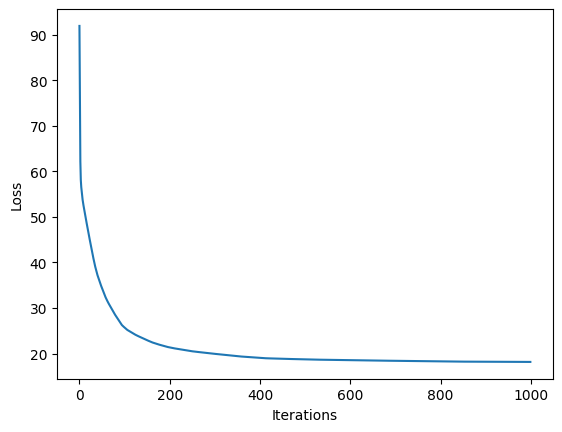

In [120]:
svc1.show_loss_curve()

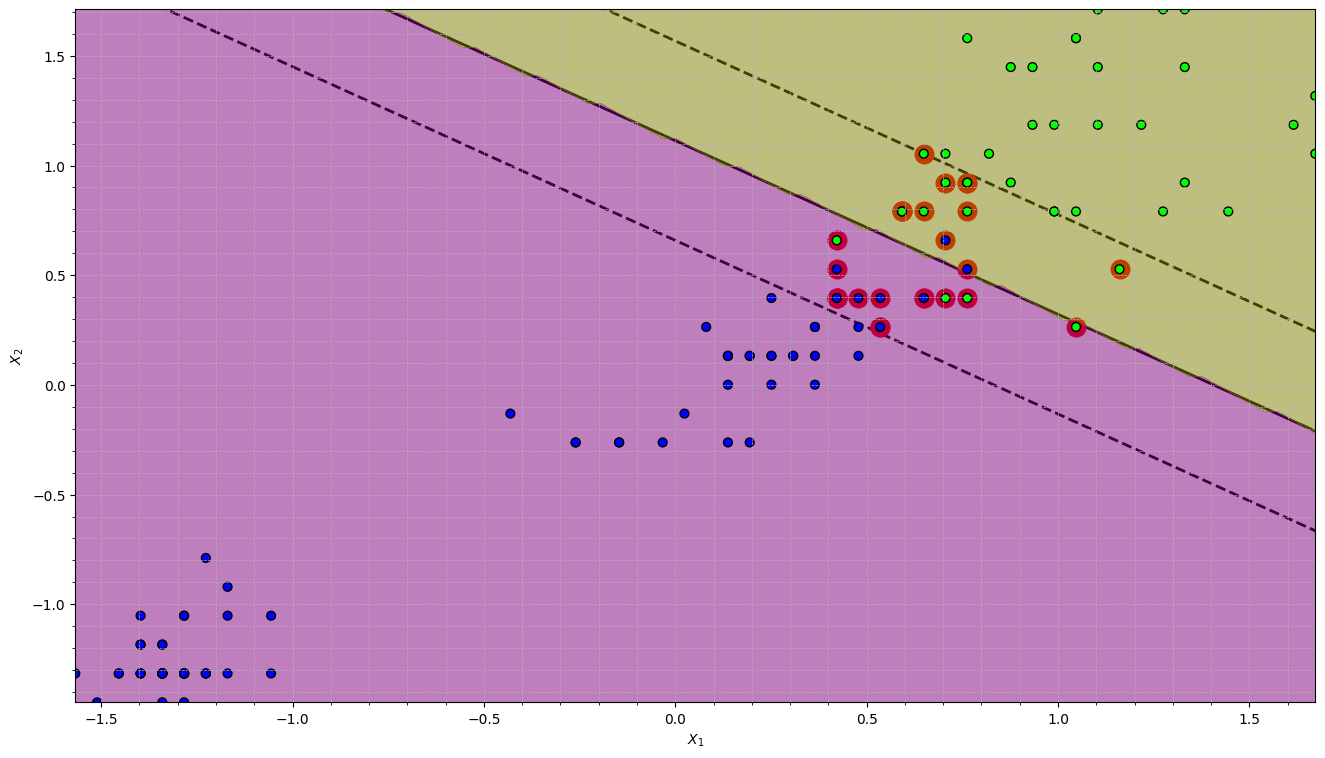

In [121]:
from AI.algorithms_from_scratch.data_plotting import Plots


plot1 = Plots()
plot1.plot_decision_boundary(svc1, X_train, y_train, svm_linear=True)

In [122]:
# CROSS VALIDATION
from sklearn.model_selection import cross_val_score

# The aim was to show you that some observations are misclassified. Meaning some are on the
# other side of the decision boundary. But it really depends on how the dataset is split since
# there are only a few datapoints the complete dataset.

scores = cross_val_score(svc1, X_test, y_test, cv=10, scoring="accuracy")
scores


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.66666667, 1.        , 1.        ])

# ------------------------------------------------------------------------------------------------
# EXAMPLE 2
My fiddling around with the code.

In [123]:
# CREATE DATA
from sklearn.datasets import make_blobs

# X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=4)
X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=2)
# X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=1.8)

In [124]:
X[:10]

array([[-0.8378134 ,  6.75487242],
       [ 7.99528046,  0.8659932 ],
       [ 2.44732866, -0.90693208],
       [ 5.68554981,  0.82576968],
       [ 4.27891901,  8.35938482],
       [ 6.5902741 ,  2.97535802],
       [ 5.81326644,  1.02336237],
       [-2.11615528, 10.43229364],
       [ 2.69656537, -0.78606665],
       [-2.57545157, 12.60340186]])

In [125]:
y[:10]

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0])

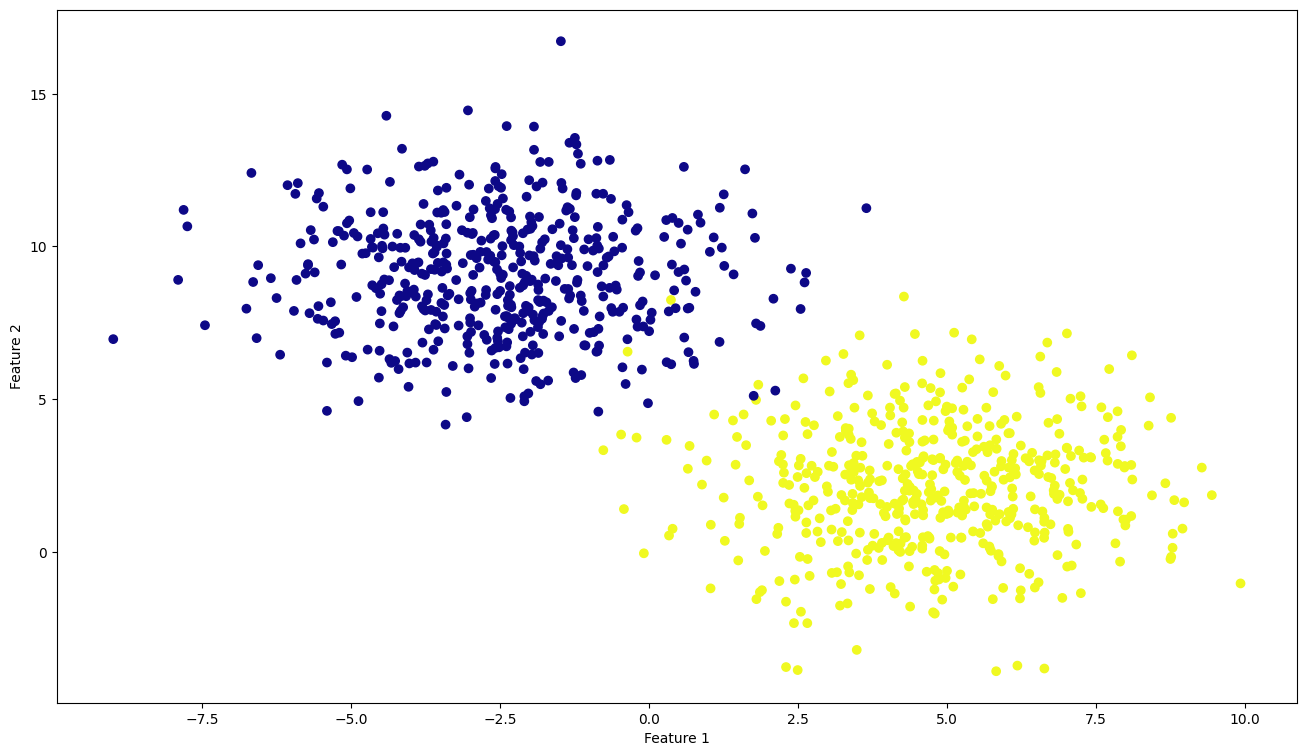

In [126]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [127]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [129]:
# TRAIN MODEL
C = 0.01
eta0 = 1
eta_d = 1000
n_epochs = 2_000
svc2 = MyLinearSoftMargSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs)
svc2.fit(X_train, y_train)

MyLinearSoftMargSVC(C=0.01, n_epochs=2000)

In [130]:
# PREDICT
y_pred = svc2.predict(X_test)

In [131]:
print(svc2.show_parameters())

coef_:
[[[ 0.74634005]
  [-0.8643857 ]]]

intercept_:
[-0.01479578]

support_vectors_:
[[ 4.48886217e-01  1.63898738e-01]
 [ 1.58878275e-01  1.16268933e+00]
 [ 7.71611944e-01 -5.15545960e-02]
 [ 8.90002132e-01 -3.24862477e-01]
 [ 1.15752796e+00  1.20328129e-01]
 [ 1.03481688e+00  1.13133029e-02]
 [ 2.56828381e-01 -6.55507633e-01]
 [-3.95392234e-01  5.60823206e-01]
 [ 4.15583346e-01 -7.41173837e-01]
 [-1.65625291e-01  5.89962675e-01]
 [ 6.37934395e-01 -2.65641700e-01]
 [ 3.32969442e-02  9.34361428e-01]
 [-2.55242432e-02  1.04888988e+00]
 [-5.00268614e-01  3.95547331e-01]
 [ 2.25095739e-01 -3.25385161e-01]
 [-7.42877448e-01  4.92495240e-01]
 [-8.54346501e-01  3.11860794e-01]
 [-1.08454410e-01 -5.30636431e-01]
 [-3.80168443e-01  5.94065458e-01]
 [ 8.77115672e-01 -5.98346245e-02]
 [-1.71591262e-01  7.35354645e-01]
 [-2.73852214e-01  4.02894203e-01]
 [-9.03435577e-02  1.36692584e-01]
 [ 1.63157636e-01 -1.56127064e-01]
 [ 4.79321676e-01 -7.00069054e-01]
 [-1.10603046e+00 -3.57271596e-01]
 [-

In [132]:
# CROSS VALIDATION
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc2, X_test, y_test, cv=10, scoring="accuracy")
scores


array([1.  , 0.95, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

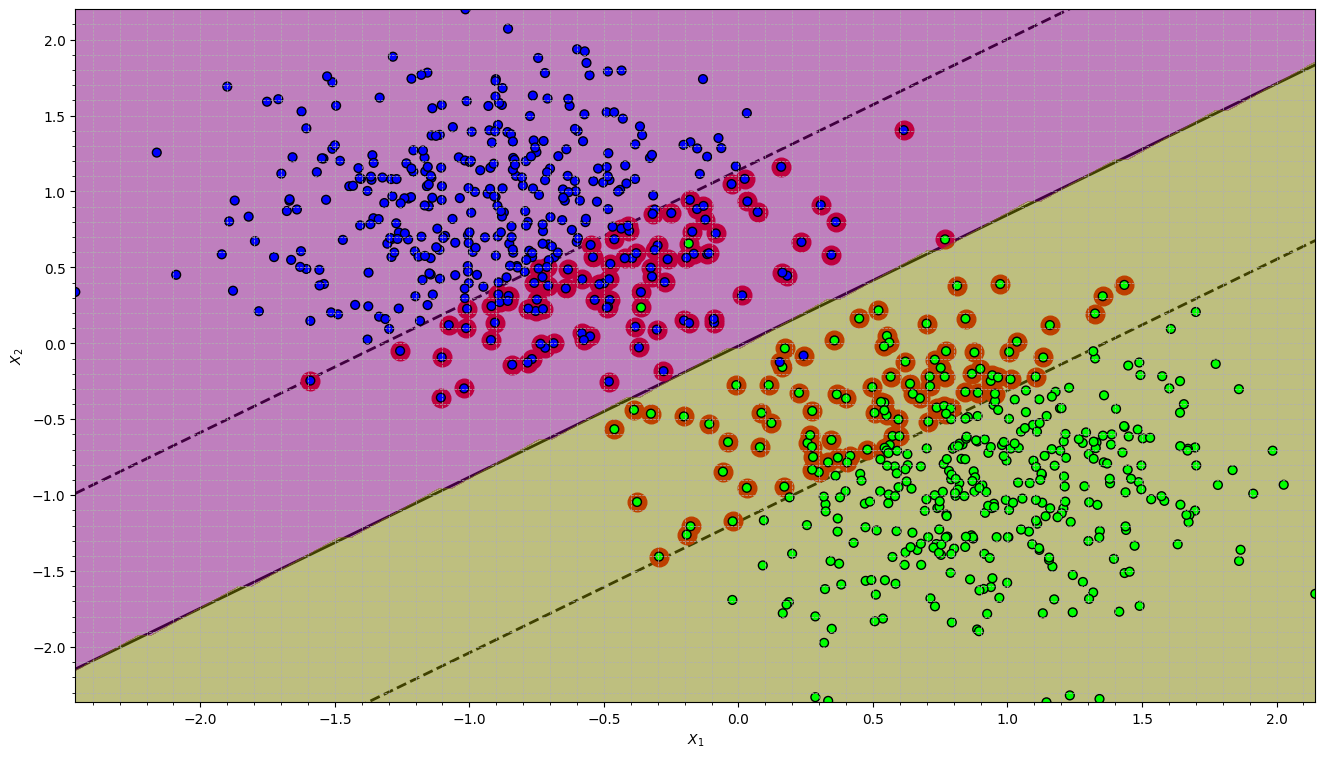

In [133]:
plot2 = Plots()
plot2.plot_decision_boundary(svc2, X_train, y_train, svm_linear=True)

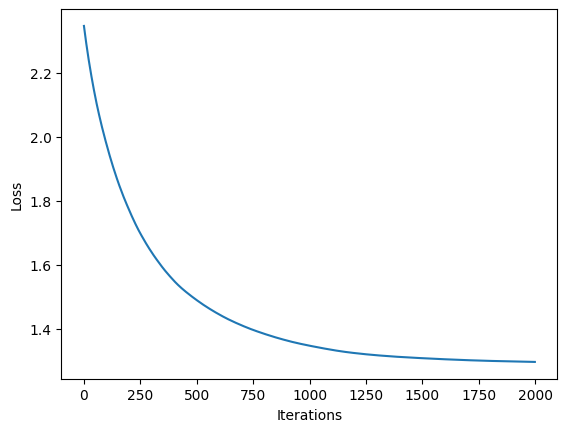

In [134]:
svc2.show_loss_curve()